In [4]:
import numpy as np
import dlib
import cv2

In [5]:
# 좌표체계 통일하기 위한 함수
def getFaceDimension(rect):
    return (rect.left(), rect.top(), rect.right() - rect.left(), rect.bottom() - rect.top())

In [6]:
# 얼굴과 눈 중심 좌표를 통해 crop
def getCropDimension(rect, center):
    width = (rect.right() - rect.left())
    half_width = width // 2
    (centerX, centerY) = center
    startX = centerX - half_width
    endX = centerX + half_width
    startY = rect.top()
    endY = rect.bottom() 
    return (startX, endX, startY, endY)    

In [11]:
# 눈만 찾음
RIGHT_EYE = list(range(36, 42))
LEFT_EYE = list(range(42, 48))
EYES = list(range(36, 48))

# 68개 landmark 찾기 위한 파일 
predictor_file = 'D:/opencv_dnn_202005/opencv_dnn_202005/model/shape_predictor_68_face_landmarks.dat'
image_file = "D:/opencv_dnn_202005/opencv_dnn_202005/image/marathon_03.jpg"

# 얼굴 detect 범위보다 좀 더 여유 공간 주기 위함
MARGIN_RATIO = 1.5
# crop 하기위한 이미지 사이즈
OUTPUT_SIZE = (300, 300)

# 얼굴을 찾아주는 detector
detector = dlib.get_frontal_face_detector()
# point를 찾아주는 predictor
predictor = dlib.shape_predictor(predictor_file)

# 이미지 읽기
image = cv2.imread(image_file)
# 각도 계산한 결과를 보여주기 위한 이미지
image_origin = image.copy()

(image_height, image_width) = image.shape[:2]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 1)

# 얼굴 찾은 개수만큼 루프 시작
for (i, rect) in enumerate(rects):
    # 좌표체계 통일하기 위한 함수
    (x, y, w, h) = getFaceDimension(rect)
    # 사각형 그려주기(녹색)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # points : 모든 68개의 point를 가져옴
    points = np.matrix([[p.x, p.y] for p in predictor(gray, rect).parts()])
    # 특정 point만 가져옴
    show_parts = points[EYES]

    # 눈 영역의 center 구하기 (Right, Left eye point의 평균점)
    right_eye_center = np.mean(points[RIGHT_EYE], axis = 0).astype("int")
    left_eye_center = np.mean(points[LEFT_EYE], axis = 0).astype("int")
    print(right_eye_center, left_eye_center)

    # right/left eye center에 원 그려줌(A)
    cv2.circle(image, (right_eye_center[0,0], right_eye_center[0,1]), 5, (0, 0, 255), -1)
    cv2.circle(image, (left_eye_center[0,0], left_eye_center[0,1]), 5, (0, 0, 255), -1)
    
    # x좌표 : Left eye center , y좌표 : Right eye center 에 초록색 원 그러줌(B)
    cv2.circle(image, (left_eye_center[0,0], right_eye_center[0,1]), 5, (0, 255, 0), -1)
    
    # right/left center를 이은 선분(C)
    cv2.line(image, (right_eye_center[0,0], right_eye_center[0,1]),
             (left_eye_center[0,0], left_eye_center[0,1]), (0, 255, 0), 2)
    
    # Right eye center에서 초록색 원으로 향하는 선분(D)
    cv2.line(image, (right_eye_center[0,0], right_eye_center[0,1]),
         (left_eye_center[0,0], right_eye_center[0,1]), (0, 255, 0), 1)
    
    # 초록색 원에서 Left eye center 방향으로 향하는 선분(E)
    cv2.line(image, (left_eye_center[0,0], right_eye_center[0,1]),
         (left_eye_center[0,0], left_eye_center[0,1]), (0, 255, 0), 1)

    # 각도 계산법(밑변과 높이의 길이를 계산해줌)
    eye_delta_x = right_eye_center[0,0] - left_eye_center[0,0]
    eye_delta_y = right_eye_center[0,1] - left_eye_center[0,1]
    # 각도를 계산해줌(arctan)
    degree = np.degrees(np.arctan2(eye_delta_y,eye_delta_x)) - 180

    # 정확도 향상을 위해 두 눈의 중심점 사이의 거리를 계산함(피타고라스 정리)
    eye_distance = np.sqrt((eye_delta_x ** 2) + (eye_delta_y ** 2))
    # affine 변환하면서 초록색 점에 기준을 맞추기 위한 비율 계산
    aligned_eye_distance = left_eye_center[0,0] - right_eye_center[0,0]
    scale = aligned_eye_distance / eye_distance

    # 파란색 원을 축으로 affine 변환
    eyes_center = ((left_eye_center[0,0] + right_eye_center[0,0]) // 2,
            (left_eye_center[0,1] + right_eye_center[0,1]) // 2)
    cv2.circle(image, eyes_center, 5, (255, 0, 0), -1)
    
    # 파란색 점, 각도, 비율을 계산한 결과를 통해 Matrix에 저장
    metrix = cv2.getRotationMatrix2D(eyes_center, degree, scale)
    cv2.putText(image, "{:.5f}".format(degree), (right_eye_center[0,0], right_eye_center[0,1] + 20),
     	 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # 선분이 그려져 있지 않은 원본 이미지를 회전시킴
    warped = cv2.warpAffine(image_origin, metrix, (image_width, image_height),
        flags=cv2.INTER_CUBIC)
    
    cv2.imshow("warpAffine", warped)
    
    # 이미지 crop(찾은 얼굴, 파란색 원 좌표)
    (startX, endX, startY, endY) = getCropDimension(rect, eyes_center)
    # 이미지 crop
    croped = warped[startY:endY, startX:endX]
    # 이미지 resize
    output = cv2.resize(croped, OUTPUT_SIZE)
    cv2.imshow("output", output)

    # 눈의 점을 찍어주는 코드(yellow점)
    for (i, point) in enumerate(show_parts):
        x = point[0,0]
        y = point[0,1]
        cv2.circle(image, (x, y), 1, (0, 255, 255), -1)

cv2.imshow("Face Alignment", image)
cv2.waitKey(0)   
cv2.destroyAllWindows()

[[294 198]] [[385 166]]


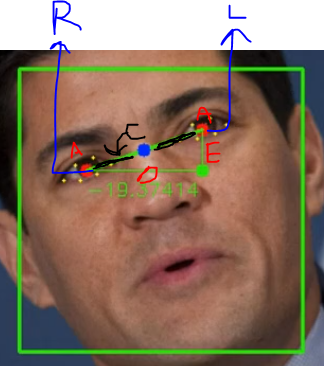

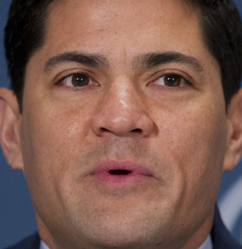